In [ ]:
import os
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from skimage.feature import local_binary_pattern
from skimage import color
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd


dataset_folder = '/drive/Colab Notebooks/Dataset/Train'
valid_folder = '/drive/Colab Notebooks/Dataset/Valid'
test_folder = '/drive/Colab Notebooks/Dataset/Test'

In [2]:
# Functie pentru a incarca imaginile dintr-un folder si a atribui etichete
def load_images_from_folder(folder, target_shape=None):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith(('.jpeg', '.jpg', '.png')):
                    img = cv2.imread(os.path.join(subfolder_path, filename))
                    if img is not None:
                        if target_shape is not None:
                            img = cv2.resize(img, target_shape)
                        images.append(img)
                        labels.append(subfolder)
                    else:
                        print(f"Warning: Unable to load {filename}")
    return images, labels


# Functie pentru a extrage caracteristici ale histogramei de culoare
def extract_color_histogram(images, bins=(8, 8, 8)):
    hist_features = []
    for img in images:
        hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        hist = cv2.calcHist([hsv_image], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        hist_features.append(hist)
    return np.array(hist_features)

# Functie pentru a extrage caracteristici de textura
def extract_lbp_features(images, radius=1, n_points=8):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-6) # Normalizare histograma
        features.append(hist)
    return np.array(features)


# Functie pentru a combina toate caracteristicile
def combine_features(images):
    color_features = extract_color_histogram(images)
    lbp_features = extract_lbp_features(images)
    return np.hstack((color_features, lbp_features))

In [ ]:
def save_results(etapa, y_true, y_pred, class_mapping):
    results_df = pd.DataFrame({'True Label': [class_mapping[label]
                                              for label in y_true],
                               'Predicted Label':
                                [class_mapping[label]
                                 for label in y_pred]})

    results_folder = '/drive/Colab Notebooks/Dataset/Results'
    if not os.path.exists(results_folder):
       os.makedirs(results_folder)

    results_file = os.path.join(results_folder, f'{etapa}_results.csv')
    results_df.to_csv(results_file, index=False)
    print(f'Results saved for {etapa} at {results_file}')

# Functie pentru salvat imaginile de validare
def save_valid_images(X_test, y_true, y_pred, class_mapping):
    results_folder = '/drive/Colab Notebooks/Dataset/Results/ImagesValid'
    if not os.path.exists(results_folder):
       os.makedirs(results_folder)

    for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        image = X_test[idx].reshape(300, 300, -1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'True Label: {class_mapping[true_label]}\nPredicted Label: {class_mapping[pred_label]}')
        plt.savefig(os.path.join(results_folder, f'valid_image_{idx}.png'))
        plt.close()


# Functie pentru salvat imaginile de testare
def save_test_images(X_test, y_true, y_pred, class_mapping):
    results_folder = '/content/drive/MyDrive/Colab Notebooks/Dataset/Results/ImagesTest'
    if not os.path.exists(results_folder):
       os.makedirs(results_folder)

    for idx, (true_label, pred_label) in enumerate(zip(y_true, y_pred)):
        image = X_test[idx].reshape(300, 300, -1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'True Label: {class_mapping[true_label]}\nPredicted Label: {class_mapping[pred_label]}')
        plt.savefig(os.path.join(results_folder, f'test_image_{idx}.png'))
        plt.close()

In [6]:
# Incarca imaginile de antrenament si etichetele
train_images, train_labels = load_images_from_folder(dataset_folder, target_shape=(300, 300))
label_mapping = {label: idx for idx, label in enumerate(set(train_labels))}
print("Label Mapping", label_mapping)
numerical_train_labels = np.array([label_mapping[label] for label in train_labels])

# Extrage caracteristicile combinate pentru antrenament
train_features = combine_features(train_images)

# Antreneaza modelul de regresie logistica
logistic_model = LogisticRegression(C = 100, random_state=42)
logistic_model.fit(train_features, numerical_train_labels)

Label Mapping {'paper': 0, 'plastic': 1}


LogisticRegression(C=100, random_state=42)

In [10]:
# Prezice pe setul de antrenare
train_predictions = logistic_model.predict(train_features)

# Evalueaza acuratetea pe setul de antrenare
print("Training Accuracy:", accuracy_score(numerical_train_labels, train_predictions))

Training Accuracy: 0.8767857142857143


Validation Accuracy: 0.8
              precision    recall  f1-score   support

       paper       0.80      0.80      0.80        50
     plastic       0.80      0.80      0.80        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



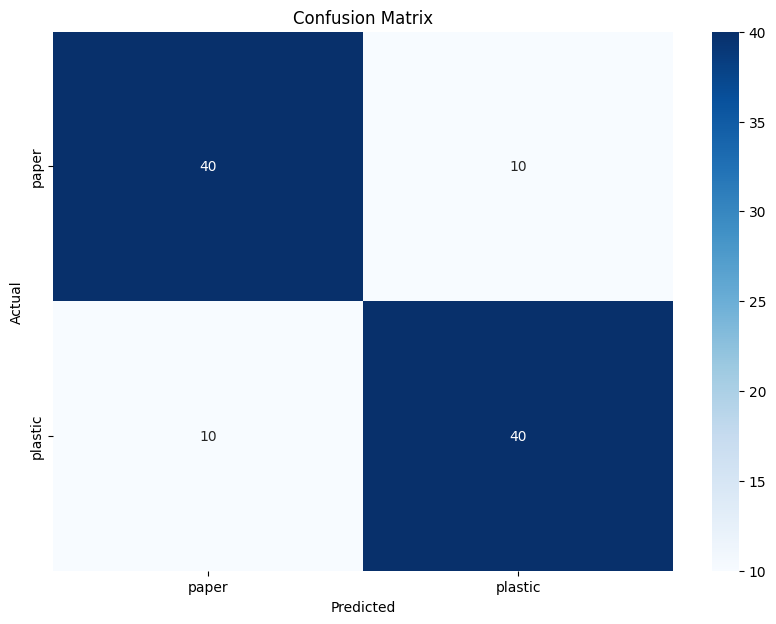

In [8]:
# Incarca imaginile de validare si etichetele
valid_images, valid_labels = load_images_from_folder(valid_folder, target_shape=(300, 300))
numerical_valid_labels = np.array([label_mapping[label] for label in valid_labels])

# Extrage caracteristicile combinate pentru validare
valid_features = combine_features(valid_images)

# Evalueaza pe setul de validare
valid_predictions = logistic_model.predict(valid_features)
print("Validation Accuracy:", accuracy_score(numerical_valid_labels, valid_predictions))

# Afiseaza raportul de clasificare
print(classification_report(numerical_valid_labels, valid_predictions, target_names=label_mapping.keys()))

# Matricea de confuzie
class_order = [1, 0]  # Paper = 1, Plastic = 0
conf_matrix = confusion_matrix(numerical_valid_labels, valid_predictions, labels = class_order)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["paper", "plastic"], yticklabels=["paper", "plastic"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Inversare mapping pentru a obtine etichetele din predictiile numerice
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
valid_predictions_labels = [reverse_label_mapping[pred] for pred in valid_predictions]

# Salvare rezultate
save_results('valid', numerical_valid_labels, valid_predictions, reverse_label_mapping)
save_valid_images(valid_images, numerical_valid_labels, valid_predictions, reverse_label_mapping)

# Afiseaza toate imaginile de validare
for i, (image, actual_label, predicted_label) in enumerate(zip(valid_images, valid_labels, valid_predictions_labels)):
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

Test Accuracy: 0.7875
              precision    recall  f1-score   support

       paper       0.79      0.78      0.78        40
     plastic       0.78      0.80      0.79        40

    accuracy                           0.79        80
   macro avg       0.79      0.79      0.79        80
weighted avg       0.79      0.79      0.79        80



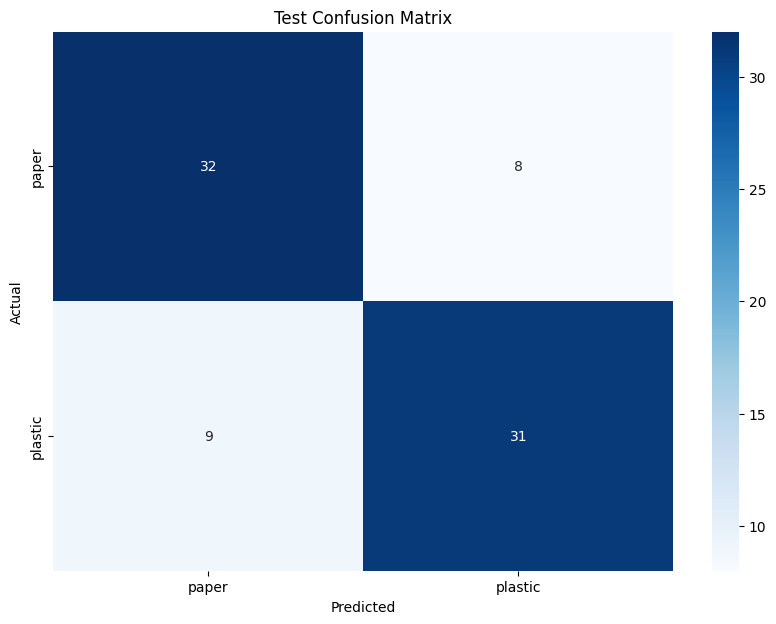

In [9]:
# Incarca imaginile de test si etichetele
test_images, test_labels = load_images_from_folder(test_folder, target_shape=(300, 300))
numerical_test_labels = np.array([label_mapping[label] for label in test_labels])

# Extrage caracteristicile combinate pentru imaginile de test
test_features = combine_features(test_images)

# Prezice pe datele de test
test_predictions = logistic_model.predict(test_features)

# Calculeaza si afiseaza acuratetea
test_accuracy = accuracy_score(numerical_test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)

# Afiseaza raportul de clasificare
print(classification_report(numerical_test_labels, test_predictions, target_names=label_mapping.keys()))

# Matricea de confuzie
class_order = [1, 0]  # Paper = 1, Plastic = 0
conf_matrix_test = confusion_matrix(numerical_test_labels, test_predictions, labels=class_order)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=["paper", "plastic"], yticklabels=["paper", "plastic"])
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Inversare mapping pentru a obtine etichetele din predictiile numerice
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}
test_predictions_labels = [reverse_label_mapping[pred] for pred in test_predictions]

# Salvare rezultate
save_results('test', numerical_test_labels, test_predictions, reverse_label_mapping)
save_test_images(test_images, numerical_test_labels, test_predictions, reverse_label_mapping)

# Afiseaza toate imaginile de test
for i, (image, actual_label, predicted_label) in enumerate(zip(test_images, test_labels, test_predictions_labels)):
        plt.figure(figsize=(4, 4))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.